# [E-06] Lyrics 작사가 인공지능 만들기 



In [1]:
import os, re 
import numpy as np
import tensorflow as tf
import glob

# Step 1.데이터 다운로드

 mkdir -p ~/aiffel/lyricist/models 
* mkdir : make directory의 약자로서 디렉토리를 생성할 때 사용하는 명령어입니다. , -p : 상위 경로도 함께 생성 models 폴더를 생성할때 lyricist 폴더가 없으면 해당옵션이 없을시 에러발생

 ln -s ~/data ~/aiffel/lyricist/data 
* ln : Link 의 약자로서 리눅스 파일시스템에서 링크파일을 만드는 명령어입니다. , -s : 심볼릭링크(단순히 원본파일을 가리키도록 링크만 시켜둔 것으로 MS의 윈도우시스템에서 흔히 사용하는 '바로가기' 같은 것)를 생성하라는 옵션



# Step 2.데이터 읽어오기

In [2]:
import os, re 
import numpy as np
import tensorflow as tf
import glob
txt_file_path = './data/lyrics/*' 

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


# Step 3. 데이터 정제


## 3.1 불필요 요소 제거 (preprocess_sentence)
1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
2. 특수문자 양쪽에 공백을 넣고
3. 여러개의 공백은 하나의 공백으로 바꿉니다
4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
5. 다시 양쪽 공백을 지웁니다
6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다

In [3]:

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


## 3.2  원하지 않는 요소 제거
* 길이 0  건너뛰기
* 길이 30이상 건너뛰기
* : 로 끝나는 줄 건너뛰기

In [4]:
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if len(sentence) >= 30: continue # 글자수 토근수 30개 이상은 건너 뛴다
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> let s just say that maybe <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>',
 '<start> had some bad love <end>',
 '<start> made my way into the sun <end>',
 '<start> my friends got their ladies <end>',
 '<start> and they re all having babies <end>',
 '<start> let s just say that maybe <end>']

처음에는 15자 이상을 넣지 않도록 했는데, 문장이 단답으로 끝나서 좀 더 풍성한 문장을 유도하기 위해 30자 이상을 넣지 않도록 했다.    
결과 문장이 조금 더 다채로워졌다. 

## 3.3 tokenize 
* fit_on_texts : 단어장 완성
* corpus-> tensor로 변환
* 입력데이타 패딩 처리

In [5]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )

    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 308  32 ...   0   0   0]
 [  2 235  14 ...   0   0   0]
 [  2  63  16 ...   0   0   0]
 ...
 [  2  20  69 ...   0   0   0]
 [  2  46  22 ...   0   0   0]
 [  2  20  69 ...   0   0   0]] <keras.preprocessing.text.Tokenizer object at 0x0000027F1A6FA790>


## 3.4 Source와 Target 추출

In [6]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2  308   32  113 4499    3    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[ 308   32  113 4499    3    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


# Step 4. 평가 데이터셋 분리

In [7]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size= 0.2  )


In [8]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  


train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# val_dataset = val_dataset.shuffle(BUFFER_SIZE) 
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

# https://www.tensorflow.org/tutorials/load_data/numpy?hl=ko

In [10]:
enc_train.shape

(54672, 19)

# Step 5. 인공지능 만들기

In [53]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.

* embedding_size를 256에서 512로 늘렸더니 val_loss값이 4.3-> 1.9로 떨어졌다. 

In [54]:
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[ 3.8165518e-04,  4.2961846e-04, -1.1484944e-04, ...,
          3.7408932e-04, -1.7964572e-04, -2.3441094e-04],
        [ 7.0546573e-04,  5.9120887e-04, -1.8376138e-04, ...,
          5.4447836e-04, -8.1669685e-05, -1.2808546e-04],
        [ 5.9210992e-04,  1.3618582e-04,  6.5528664e-05, ...,
          3.6543721e-04, -3.7849724e-04, -3.8533890e-05],
        ...,
        [ 4.3125269e-03,  1.5601229e-03, -4.8207394e-03, ...,
          2.2424394e-03, -3.0119768e-03, -1.8783218e-03],
        [ 4.4125728e-03,  1.7320473e-03, -5.0692670e-03, ...,
          2.2901995e-03, -3.1698633e-03, -1.8435601e-03],
        [ 4.4990084e-03,  1.8930712e-03, -5.2842814e-03, ...,
          2.3278042e-03, -3.3064925e-03, -1.8076940e-03]],

       [[ 3.8165518e-04,  4.2961846e-04, -1.1484944e-04, ...,
          3.7408932e-04, -1.7964572e-04, -2.3441094e-04],
        [ 5.2502693e-04,  4.5941328e-04, -2.1797638e-04, ...,
          4.0476723e-04, 

In [38]:
model.summary()

Model: "text_generator_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  3072256   
                                                                 
 lstm_10 (LSTM)              multiple                  5246976   
                                                                 
 dropout_5 (Dropout)         multiple                  0 (unused)
                                                                 
 lstm_11 (LSTM)              multiple                  8392704   
                                                                 
 dropout_6 (Dropout)         multiple                  0 (unused)
                                                                 
 dense_5 (Dense)             multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,

# Step 6. 인공지능 훈련 

In [39]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
history= model.fit(train_dataset, epochs=30 , validation_data = val_dataset) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/30
213/213 [==============================] - 62s 281ms/step - loss: 2.0523 - val_loss: 1.6722
Epoch 2/30
213/213 [==============================] - 62s 291ms/step - loss: 1.5982 - val_loss: 1.5711
Epoch 3/30
213/213 [==============================] - 61s 286ms/step - loss: 1.5020 - val_loss: 1.5085
Epoch 4/30
213/213 [==============================] - 61s 287ms/step - loss: 1.4330 - val_loss: 1.4638
Epoch 5/30
213/213 [==============================] - 55s 260ms/step - loss: 1.3773 - val_loss: 1.4337
Epoch 6/30
213/213 [==============================] - 54s 252ms/step - loss: 1.3275 - val_loss: 1.4068
Epoch 7/30
213/213 [==============================] - 61s 288ms/step - loss: 1.2817 - val_loss: 1.3805
Epoch 8/30
213/213 [==============================] - 54s 253ms/step - loss: 1.2392 - val_loss: 1.3609
Epoch 9/30
213/213 [==============================] - 54s 254ms/step - loss: 1.1994 - val_loss: 1.3409
Epoch 10/30
213/213 [==============================] - 58s 270ms/step - l

## 6-1 Valication Loss

In [40]:
model.evaluate(enc_val, dec_val, verbose = 2)

428/428 - 9s - loss: 1.2474 - 9s/epoch - 21ms/step


1.2473613023757935

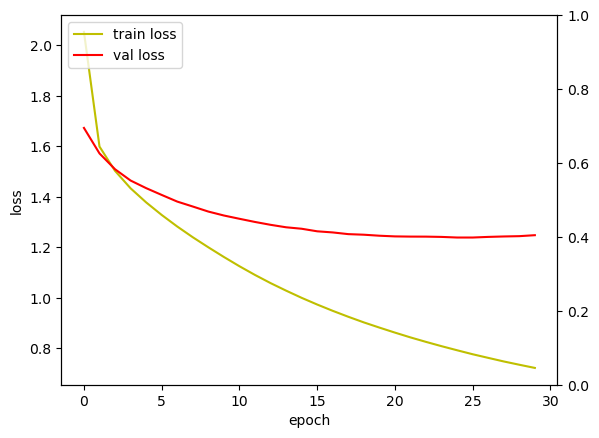

In [41]:

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

# Step 7. 문장 생성

In [42]:
#문장생성 함수 정의

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [43]:
generate_text(model, tokenizer, init_sentence="<start> under the") # 시작문장으로 he를 넣어 문장생성 함수 실행

'<start> under the sea under the sea <end> '

In [44]:
generate_text(model, tokenizer, init_sentence="<start> cold")

'<start> cold heart <end> '

In [45]:
generate_text(model, tokenizer, init_sentence="<start> what i")

'<start> what i need i i i i <end> '

In [46]:
generate_text(model, tokenizer, init_sentence="<start> hot")

'<start> hot and fresh out the kitchen <end> '

In [47]:
generate_text(model, tokenizer, init_sentence="<start> but i")

'<start> but i m not the only one <end> '

In [48]:
generate_text(model, tokenizer, init_sentence="<start> yet")

'<start> yet i m definitive <end> '

In [49]:
generate_text(model, tokenizer, init_sentence="<start> chorus")

'<start> chorus <end> '

In [50]:
generate_text(model, tokenizer, init_sentence="<start> the dog")

'<start> the dog and the wren <end> '

In [51]:
generate_text(model, tokenizer, init_sentence="<start> a cat")

'<start> a cat and the miller <end> '

under the sea under the sea 
cold heart
what i need 
hot and fresh out the kitchen
but i m not the only one
yet i m definitive
chorus 
the dog and the wren
a cat and the miller 


# 회고

* 처음 로딩된 텍스트에서 불필요한 요소를 제거하는 부분에서 15자 이상을 넣지 않도록 했더니, 문장의 구성이 단조롭고,    
단답형이어서 30자 이상으로 조정했더니 만족할 만한 수준이 되었다. 
* train_test_split을 통해서 Train Set와 Test Set를 분리하면서 Array 타입이여서 model에 넣기 위해서는 tensor로 변환해 주어야 한다는 것을 알았다. 
* 처음에 val_loss가 4.3로 너무 높게 나와서 embedding_size을 256->512로 조정하니 val_loss값이 4.3-> 1.9로 떨어졌다.  
* 말뭉치를 이용해 이것을 Embedding Layer를 통해 컴퓨터용 사전이 만들어 지고, Tensor 로 변환되는 Model에서 훈련되는 과정을 진행했다. 
* 해당 프로젝트를 진행하기 전에 CPU 기반으로 epochs 30을 돌렸을 때 1시간이 넘었는데, GPU인식으로 돌리니 대략 30분 정도 걸렸다. 


